## Ensemble variation in cloud cover
### GEFS TCC
The NOAA GEFS numerical weather prediction (NWP) model is a 30-member ensemble version of the GFS model. NOAA has this description:
> The GEFS attempts to quantify the amount of uncertainty in a forecast by generating an ensemble of multiple forecasts, each minutely different, or perturbed, from the original observations. With global coverage, GEFS is produced four times a day with weather forecasts going out to 16 days.

We will look at the fleet-wide weighted average standard deviation of the Total Cloud Cover (TCC) percentage across all 30 members, weighted by the solar plant capacities. For example, if all 30 members forecast that a given location and time will have no clouds (TCC = 0%), then the standard deviation will be *low*, so we assume that our power forecast has *low uncertainty*. If there is significant disagreement between the 30 members (some members forecast no or low cloud cover, while others forecast high cloud cover), then the standard deviation will be *high*, and we assume that any forecast will have *high uncertainty*. 

We use TCC instead of irradiance for two reasons: 
 1) GFS is known to have issues with modeling irradiance, and 
 2) We are looking at *relative* uncertainty, and using TCC means we don't have to normalize irradiance to clear sky irradiance. 

In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np

from herbie import Herbie
from paint.standard2 import cm_tmp, cm_wind, cm_wave_height, cm_pcp
from toolbox import EasyMap, pc
import xarray as xr
import pandas as pd
import datetime
from datetime import timedelta
import time
import pickle

## Plant data

Let's load plant data again:

In [238]:
plants_df = pd.read_csv(r'C:\Users\willh\Documents\Python Scripts\herbie_examples\pv_fleet_metadata_rev3.csv') # read in as a Pandas DataFrame
plants_df = plants_df[plants_df['ac_capacity']>=10].copy().reset_index()
num_plants = len(plants_df.index) # number of plants

To keep it simple at the beginning, let's just work with the first 2 plants:

In [241]:
plants_df_partial = plants_df.head(2).copy()

### GEFS Total Cloud Cover
Now, let's use `Herbie` to get Total Cloud Cover from GEFS. Total Cloud Cover is `TCDC` in the GEFS inventory, even though we refer to it as TCC elsewhere. We will also pick a single member of the GEFS ensemble - let's use "p01" to start. See [1] for more details.

[1] https://herbie.readthedocs.io/en/stable/user_guide/_model_notebooks/gefs.html

In [242]:
member='p01'
ds = Herbie(
    date='2023-02-10 06:00',
    model='gefs',
    product="atmos.5",
    member=member,
    fxx=36).xarray('TCDC',remove_grib=True)

✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2023-Feb-10 06:00 UTC F36 ┊ GRIB2 @ aws ┊ IDX @ aws


c:\Users\willh\miniforge3\envs\pvlib_herbie_env2\Lib\site-packages\herbie\core.py:1096: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


And preview the dataset. Note that "tcc" is the variable name for Total Cloud COver within the xarray dataset.

In [243]:
ds

<xarray.Dataset> Size: 1MB
Dimensions:              (latitude: 361, longitude: 720)
Coordinates:
    number               int32 4B 1
    time                 datetime64[ns] 8B 2023-02-10T06:00:00
    step                 timedelta64[ns] 8B 1 days 12:00:00
    atmosphere           float64 8B 0.0
  * latitude             (latitude) float64 3kB 90.0 89.5 89.0 ... -89.5 -90.0
  * longitude            (longitude) float64 6kB 0.0 0.5 1.0 ... 359.0 359.5
    valid_time           datetime64[ns] 8B ...
Data variables:
    tcc                  (latitude, longitude) float32 1MB ...
    gribfile_projection  object 8B None
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          2
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   gefs
    product:                 atmos.5
    description:             Global Ensemble Forecast System (GEFS)
    remote_grib:             https://noaa-gefs-pds.s3.amazonaws.com/gefs.2023...
    local_grib:              C:\Users\willh\data\gefs\20230210\subset_db0efd3...
    searchString:            TCDC

Similar to what we did with the HRRR forecast, we will slice the dataset to reduce file size and make it easier to plot. Note that GEFS is mush lower resolution than HRRR, so file size is not a big issue. 

In [244]:
# Define extent (left lon, right lon, lower lat, upper lat)
# longitude has to be between 0 and 360
region_extent = [-92, -80, 29, 36]

min_lon = (region_extent[0]+360) % 360
max_lon = (region_extent[1]+360) % 360
min_lat = region_extent[2]
max_lat = region_extent[3]

# slice to region extent
# note that lat is sliced max to min because of order that latitude is stored in with GEFS
# (I think...)
ds = ds.sel(latitude=slice(max_lat, min_lat), longitude=slice(min_lon,max_lon))

### Pull TCC for each plant
Now, let's pull out the data from the dataset for each plant and put it in a dataframe:

In [245]:
# GEFS uses longitudes in [0,360), so use modulo to convert lon to be 0 <= lon < 360
lon_gefs = [(x + 360) % 360 for x in plants_df_partial.longitude]

# select the whole list of sites at once
lats = xr.DataArray(plants_df_partial.latitude.values, dims='plant_number') 
lons = xr.DataArray(lon_gefs, dims='plant_number')
df1 = ds.sel(latitude = lats, longitude = lons, method = 'nearest').to_dataframe()

# assign ac capacity based on plant_number and index in plants_df_partial
df1 = df1.merge(plants_df_partial[['ac_capacity']], left_on='plant_number', right_index=True)

# preview the dataframe
df1.head()

,number,time,step,atmosphere,latitude,longitude,valid_time,tcc,gribfile_projection,ac_capacity
plant_number,,,,,,,,,,
0,1,2023-02-10 06:00:00,1 days 12:00:00,0.0,30.5,275.5,2023-02-11 18:00:00,100.0,None,213.0
1,1,2023-02-10 06:00:00,1 days 12:00:00,0.0,32.5,276.5,2023-02-11 18:00:00,100.0,None,204.0


And let's make a map. 

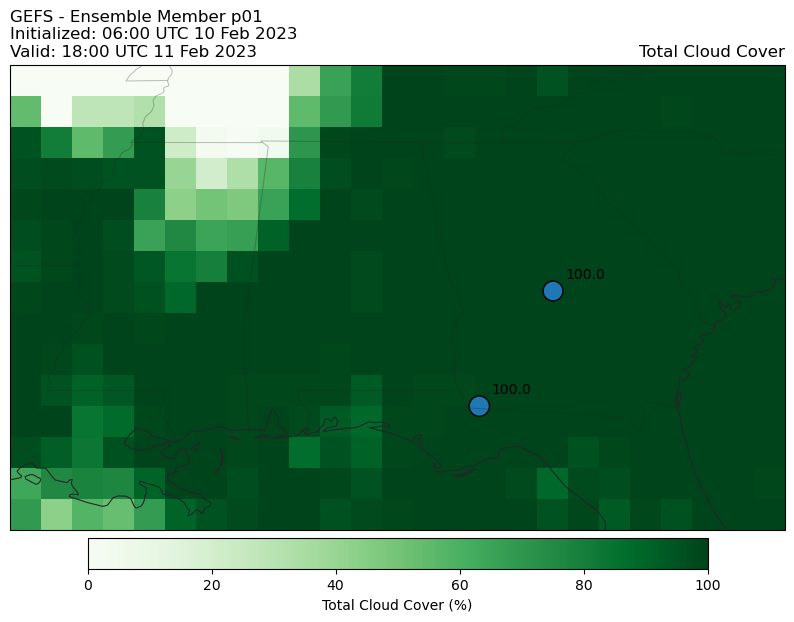

In [246]:
ax = EasyMap("50m", crs=ds.herbie.crs, figsize=[10, 10]).STATES().BORDERS().ax
p = ax.pcolormesh(
    ds.longitude, ds.latitude, ds['tcc'], transform=pc, cmap="Greens", vmin=0
)

# add a colorbar
plt.colorbar(
    p,
    ax=ax,
    orientation="horizontal",
    pad=0.01,
    shrink=0.8,
    label=f"{ds['tcc'].GRIB_name} ({ds['tcc'].GRIB_units})",
)

# add plant markers with size corresponding to ac capacity
plt.scatter(plants_df_partial.longitude, plants_df_partial.latitude, s=plants_df_partial.ac_capacity,
            edgecolors='black', transform=pc)

# add data labels
for i, txt in enumerate(df1['tcc']):
    plt.annotate(txt, (plants_df_partial.longitude[i]+.2, plants_df_partial.latitude[i]+.2))

ax.set_title(
    f"{ds.model.upper()} - Ensemble Member {member} \
    \nInitialized: {ds.time.dt.strftime('%H:%M UTC %d %b %Y').item()} \
    \nValid: {ds.valid_time.dt.strftime('%H:%M UTC %d %b %Y').item()}",
    loc="left",
)
ax.set_title(ds['tcc'].GRIB_name, loc="right")
plt.show()

### Weighted average TCC
Here, the total cloud cover for each plant is 100%. We can calculate the weighted average total cloud cover, weightde by plant AC capacity, like this:

In [247]:
weighted_avg_tcc1 = df1.filter(regex='tcc').multiply(plants_df_partial['ac_capacity'].values,axis='index').sum()/plants_df['ac_capacity'].sum()
weighted_avg_tcc1 = weighted_avg_tcc1.values[0]
print('Weighted Average TCC: ' + str(weighted_avg_tcc1))

Weighted Average TCC: 100.0


### Repeating for more ensemble members
Now, let's make a helper function to repeat that for different forecasts/members:

In [261]:
def sample_tcc_function(member, date, plants_df, plot=True):
    ds = Herbie(
        date=date,
        model='gefs',
        product="atmos.5",
        member=member,
        fxx=36).xarray('TCDC',remove_grib=True)

    # slice to region extent
    ds = ds.sel(latitude=slice(max_lat, min_lat), longitude=slice(min_lon,max_lon))

    # select values for each plant, assign ac capacity
    # GEFS uses longitudes in [0,360), so use modulo to convert lon to be 0 <= lon < 360
    lon_gefs = [(x + 360) % 360 for x in plants_df.longitude]
    lats = xr.DataArray(plants_df.latitude.values, dims='plant_number') 
    lons = xr.DataArray(lon_gefs, dims='plant_number')
    df = ds.sel(latitude = lats, longitude = lons, method = 'nearest').to_dataframe()
    df = df.merge(plants_df[['ac_capacity']], left_on='plant_number', right_index=True)

    if plot==True:
        # plot
        ax = EasyMap("50m", crs=ds.herbie.crs, figsize=[10, 10]).STATES().BORDERS().ax
        p = ax.pcolormesh(
            ds.longitude, ds.latitude, ds['tcc'], transform=pc, cmap="Greens", vmin=0
        )

        # add a colorbar
        plt.colorbar(
            p,
            ax=ax,
            orientation="horizontal",
            pad=0.01,
            shrink=0.8,
            label=f"{ds['tcc'].GRIB_name} ({ds['tcc'].GRIB_units})",
        )

        # add plant markers with size corresponding to ac capacity
        plt.scatter(plants_df.longitude, plants_df.latitude, s=plants_df.ac_capacity,
                    edgecolors='black', transform=pc)

        # add data labels
        for i, txt in enumerate(df['tcc']):
            plt.annotate(txt, (plants_df.longitude[i]+.2, plants_df.latitude[i]+.2))

        ax.set_title(
            f"{ds.model.upper()} - Ensemble Member {member} \
            \nInitialized: {ds.time.dt.strftime('%H:%M UTC %d %b %Y').item()} \
            \nValid: {ds.valid_time.dt.strftime('%H:%M UTC %d %b %Y').item()}",
            loc="left",
        )
        ax.set_title(ds['tcc'].GRIB_name, loc="right")
        plt.show()

    # weighted average tcc
    weighted_avg_tcc = df.filter(regex='tcc').multiply(plants_df['ac_capacity'].values,axis='index').sum()/plants_df['ac_capacity'].sum()
    weighted_avg_tcc = weighted_avg_tcc.values[0]
    return df, weighted_avg_tcc

Let's try it again for another one of the GEFS members, `p02`. We will write the TCC values for each plant to a new DataFrame, `df2`.

✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2023-Feb-10 06:00 UTC F36 ┊ GRIB2 @ aws ┊ IDX @ aws


c:\Users\willh\miniforge3\envs\pvlib_herbie_env2\Lib\site-packages\herbie\core.py:1096: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


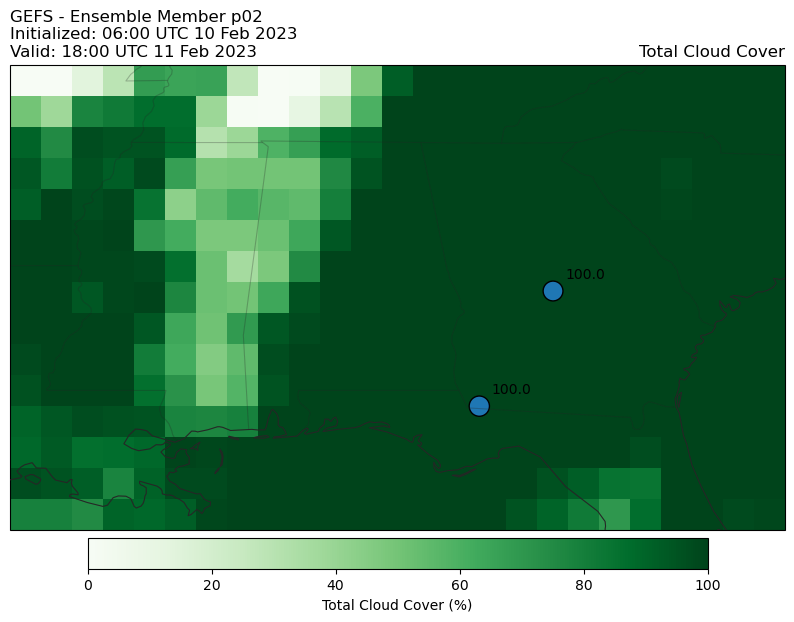

Weighted Average TCC: 100.0


In [249]:
df2, weighted_avg_tcc2 = sample_tcc_function(member='p02', date='2023-02-10 06:00', plants_df=plants_df_partial)
print('Weighted Average TCC: ' + str(weighted_avg_tcc2))

And again for `p03`:

✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2023-Feb-10 06:00 UTC F36 ┊ GRIB2 @ aws ┊ IDX @ aws


c:\Users\willh\miniforge3\envs\pvlib_herbie_env2\Lib\site-packages\herbie\core.py:1096: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


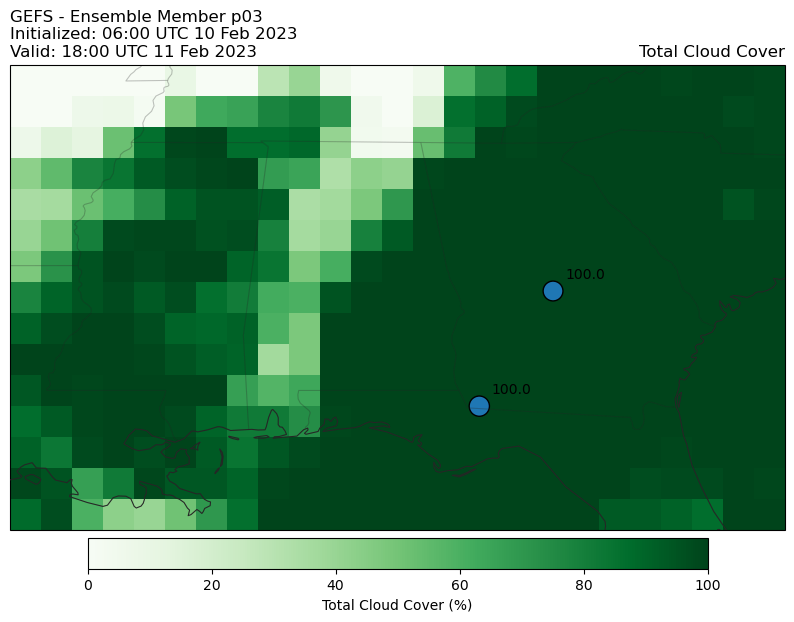

Weighted Average TCC: 100.0


In [250]:
df3, weighted_avg_tcc3 = sample_tcc_function(member='p03', date='2023-02-10 06:00', plants_df=plants_df_partial)
print('Weighted Average TCC: ' + str(weighted_avg_tcc3))

If there were only 3 members, we could stop there and calculate the standard deviation of weighted average TCCs from each member:

In [251]:
print(np.std([weighted_avg_tcc1, weighted_avg_tcc2, weighted_avg_tcc3]))

0.0


Because the weighted average TCC was 100% for each member, the standard devation is zero. This indicates that there would be a relatively low uncertainty forecast for the day/time. 

### Again for another day
Let's do the same thing, but for the next day:

✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2023-Feb-11 06:00 UTC F36 ┊ GRIB2 @ aws ┊ IDX @ aws


c:\Users\willh\miniforge3\envs\pvlib_herbie_env2\Lib\site-packages\herbie\core.py:1096: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


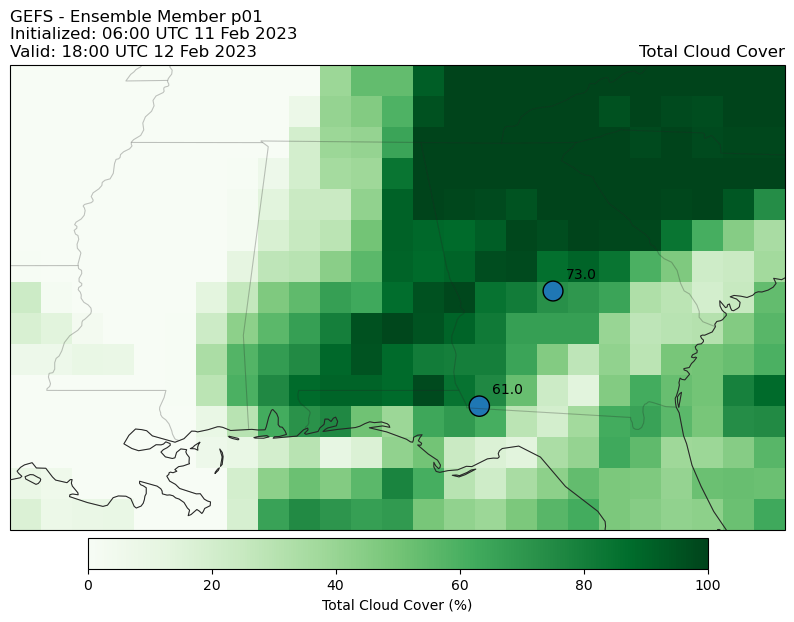

Weighted Average TCC: 66.87050359712231
✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2023-Feb-11 06:00 UTC F36 ┊ GRIB2 @ aws ┊ IDX @ aws


c:\Users\willh\miniforge3\envs\pvlib_herbie_env2\Lib\site-packages\herbie\core.py:1096: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


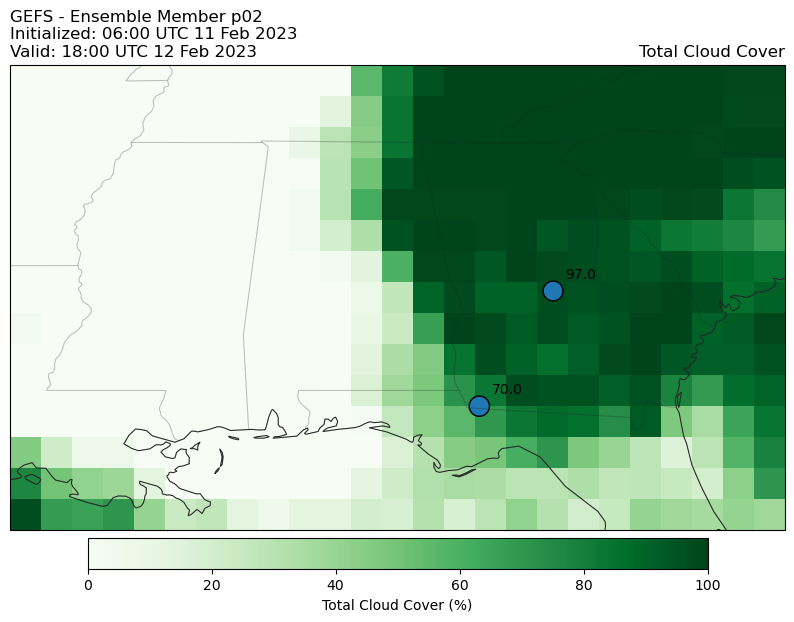

Weighted Average TCC: 83.20863309352518
✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2023-Feb-11 06:00 UTC F36 ┊ GRIB2 @ aws ┊ IDX @ aws


c:\Users\willh\miniforge3\envs\pvlib_herbie_env2\Lib\site-packages\herbie\core.py:1096: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


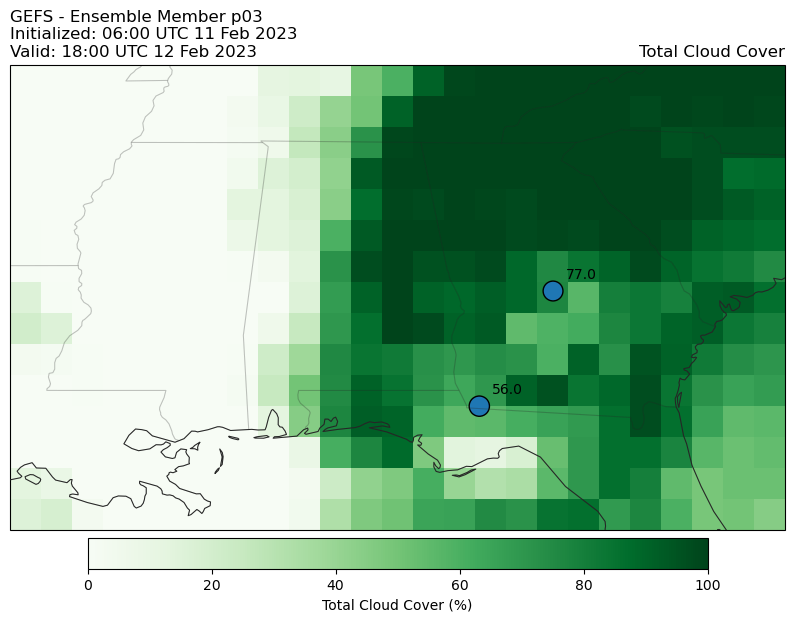

Weighted Average TCC: 66.27338129496403
StDev of Weighted Avg TCC: 7.8463989190061865


In [252]:
df1, weighted_avg_tcc1 = sample_tcc_function(member='p01', date='2023-02-11 06:00', plants_df=plants_df_partial)
print('Weighted Average TCC: ' + str(weighted_avg_tcc1))
df2, weighted_avg_tcc2 = sample_tcc_function(member='p02', date='2023-02-11 06:00', plants_df=plants_df_partial)
print('Weighted Average TCC: ' + str(weighted_avg_tcc2))
df3, weighted_avg_tcc3 = sample_tcc_function(member='p03', date='2023-02-11 06:00', plants_df=plants_df_partial)
print('Weighted Average TCC: ' + str(weighted_avg_tcc3))

print('StDev of Weighted Avg TCC: ' + str(np.std([weighted_avg_tcc1, weighted_avg_tcc2, weighted_avg_tcc3])))

This indicates higher uncertainty than for the first day. 

### And for a third day
One more time:

✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2023-Feb-12 06:00 UTC F36 ┊ GRIB2 @ aws ┊ IDX @ aws


c:\Users\willh\miniforge3\envs\pvlib_herbie_env2\Lib\site-packages\herbie\core.py:1096: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


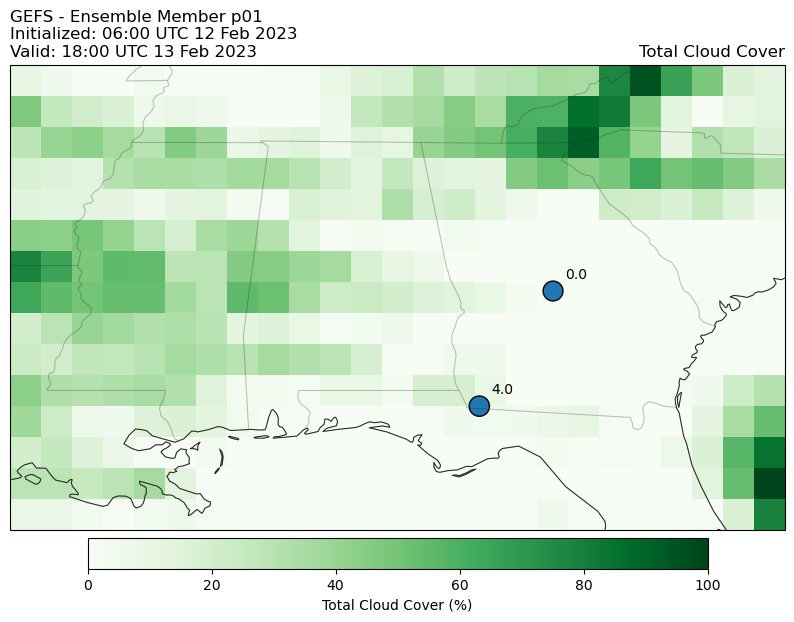

Weighted Average TCC: 2.0431654676258995
✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2023-Feb-12 06:00 UTC F36 ┊ GRIB2 @ aws ┊ IDX @ aws


c:\Users\willh\miniforge3\envs\pvlib_herbie_env2\Lib\site-packages\herbie\core.py:1096: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


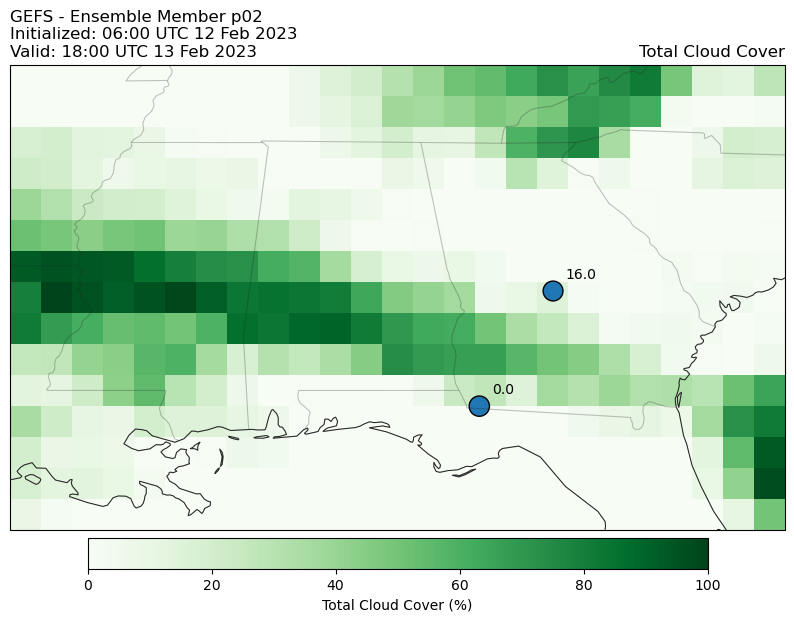

Weighted Average TCC: 7.827338129496403
✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2023-Feb-12 06:00 UTC F36 ┊ GRIB2 @ aws ┊ IDX @ aws


c:\Users\willh\miniforge3\envs\pvlib_herbie_env2\Lib\site-packages\herbie\core.py:1096: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


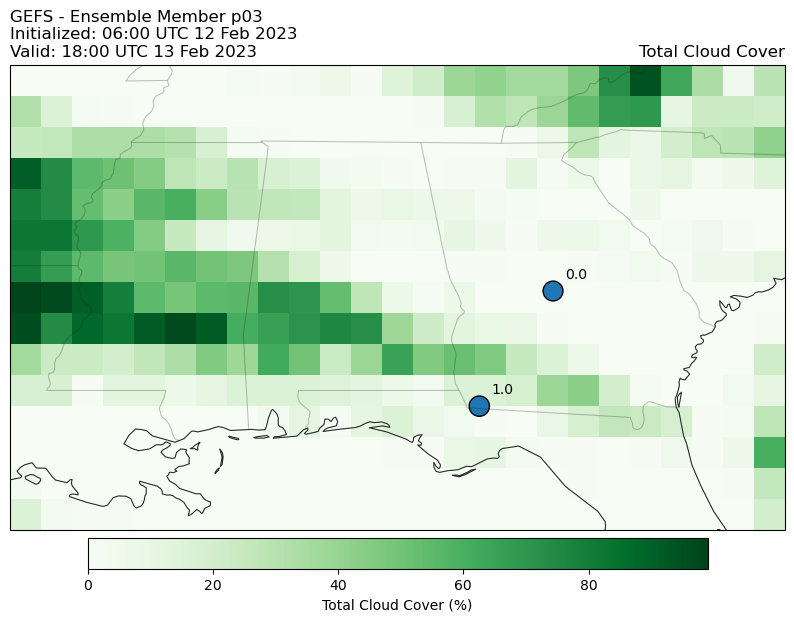

Weighted Average TCC: 0.5107913669064749
StDev of Weighted Avg TCC: 3.150602769419263


In [253]:
df1, weighted_avg_tcc1 = sample_tcc_function(member='p01', date='2023-02-12 06:00', plants_df=plants_df_partial)
print('Weighted Average TCC: ' + str(weighted_avg_tcc1))
df2, weighted_avg_tcc2 = sample_tcc_function(member='p02', date='2023-02-12 06:00', plants_df=plants_df_partial)
print('Weighted Average TCC: ' + str(weighted_avg_tcc2))
df3, weighted_avg_tcc3 = sample_tcc_function(member='p03', date='2023-02-12 06:00', plants_df=plants_df_partial)
print('Weighted Average TCC: ' + str(weighted_avg_tcc3))

print('StDev of Weighted Avg TCC: ' + str(np.std([weighted_avg_tcc1, weighted_avg_tcc2, weighted_avg_tcc3])))

This indicates medium uncertainty, at least compared to the first two days. 

### Expanding to all 30 ensemble members and all plants
Now that we've done a few limited illustrations, lets try looping through all 30 ensemble members, and calculating weighted average TCC for all of the plants in our list. _Note that this could take a few minutes to run._

In [262]:
date = '2023-02-11 06:00'

num_members = 30

# list of GEFS ensemble members, e.g., 'p01', 'p02', etc.
member_list = [f"p{x:02d}" for x in range(1, num_members+1)]

df_dict = {}
weighted_avg_tcc_dict = {}
for x in range(0, num_members):
    df_dict[x], weighted_avg_tcc_dict[x] = sample_tcc_function(member=member_list[x], date=date, plants_df=plants_df, plot=False)

std_wavg_tcc = np.std(list(weighted_avg_tcc_dict.values()))
print(print('StDev of Weighted Avg TCC: ' + str(std_wavg_tcc)))

✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2023-Feb-11 06:00 UTC F36 ┊ GRIB2 @ aws ┊ IDX @ aws


c:\Users\willh\miniforge3\envs\pvlib_herbie_env2\Lib\site-packages\herbie\core.py:1096: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2023-Feb-11 06:00 UTC F36 ┊ GRIB2 @ aws ┊ IDX @ aws


c:\Users\willh\miniforge3\envs\pvlib_herbie_env2\Lib\site-packages\herbie\core.py:1096: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2023-Feb-11 06:00 UTC F36 ┊ GRIB2 @ aws ┊ IDX @ aws


c:\Users\willh\miniforge3\envs\pvlib_herbie_env2\Lib\site-packages\herbie\core.py:1096: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2023-Feb-11 06:00 UTC F36 ┊ GRIB2 @ aws ┊ IDX @ aws


c:\Users\willh\miniforge3\envs\pvlib_herbie_env2\Lib\site-packages\herbie\core.py:1096: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2023-Feb-11 06:00 UTC F36 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2023-Feb-11 06:00 UTC F36 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2023-Feb-11 06:00 UTC F36 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2023-Feb-11 06:00 UTC F36 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2023-Feb-11 06:00 UTC F36 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2023-Feb-11 06:00 UTC F36 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2023-Feb-11 06:00 UTC F36 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2023-Feb-11 06:00 UTC F36 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2023-Feb-11 06:00 UTC F36 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2023-Feb-11 06:00 UTC F36 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2023-Feb-11 06:00 UTC F36 ┊ G